# Проект по анализу оттока клиентов регионального банка

Цель - проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка и дать рекомендации по удержанию клиентов.

1. [Исследовательский анализ данных](#EDA)
2. [Сформировать портреты клиентов, которые склонны уходить из банка](#analysis)
3. [Проверка статистических гипотез](#hypothesis)
4. [Выводы и рекомендации](#summary)

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools
from sklearn.preprocessing import LabelEncoder
from scipy import stats as st

## Исследовательский анализ данных
<a id="EDA"></a>

In [2]:
data_churn = pd.read_csv('../projects/bank_dataset.csv')

In [3]:
data_churn.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [4]:
data_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
len(data_churn['userid'].unique())

10000

In [6]:
data_churn.columns = data_churn.columns.str.lower()
data_churn.rename(columns = {'userid' : 'user_id','creditcard':'credict_card'}, inplace = True)

In [7]:
print(data_churn['city'].unique())
print(data_churn['gender'].unique())
print(data_churn['objects'].unique())
print(data_churn['products'].unique())

['Ярославль' 'Рыбинск' 'Ростов Великий']
['Ж' 'М']
[ 2  1  8  7  4  6  3 10  5  9  0]
[1 3 2 4]


In [8]:
print(data_churn.groupby('gender')['user_id'].count())

gender
Ж    4543
М    5457
Name: user_id, dtype: int64


Переменные пола и города - категориальные. Для проведения кластеризации далее в проекте переведу значения в числовые.

In [9]:
data_churn.describe()

,user_id,score,age,objects,balance,products,credict_card,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


В датафрейме 10000 наблюдений и 12 полей - 11 признаков и целевая переменная. Дубликатов нет, пропущенные значения есть только в столбце Balance. Типы данных корректны. Переименовала для удобства названия столбцов. 

Данные по трем городам - Ростов Великий, Ярославль и Рыбинск. Количество объектов в собственности - от 0 до 10, количество продуктов, которыми пользуется клиент - от 1 до 4. В среднем клиенты используют 1-2 продукта, в среднем объектов собственности у клиента - 5.Примерно одинаковое соотношение мужчин и женщин. Большой разброс по параметрам score, salary и age. Средний возраст клиента банка - 39 лет. В отток попадает ~ 20% всех клиентов.

Далее изучу пропуски. Есть предположение, что пропуски в основном у тех клиентов, которые попали в отток. Выделю отдельно датасет в котором Balance Nan.

In [10]:
balance_nan = data_churn[data_churn['balance'].isnull()]

In [11]:
balance_nan['churn'].value_counts()

0    3117
1     500
Name: churn, dtype: int64

In [12]:
print((balance_nan['churn'].value_counts()/data_churn['churn'].value_counts()).map(lambda n: '{:,.2%}'.format(n)))

0    39.14%
1    24.55%
Name: churn, dtype: object


Из всего количества клиентов с пропущенным Balance, только 500 попали в отток. Это составляет четверть общего количества клиентов, попавших в отток. Предположение не сработало, изучу другие признаки.

In [13]:
print(balance_nan['city'].value_counts())

Ярославль    2418
Рыбинск      1199
Name: city, dtype: int64


In [14]:
print(data_churn['city'].value_counts())

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64


Изучив пропуски по городам, видим, что пропуски есть у клиентов в Ярославле и Рыбинске и нет по Ростову. В данном случае сложно сделать предположение о природе пропусков, так как видим, что количество клиентов в областных городах Ярославля одинаковое, но пропуски есть только по Рыбинску и самому Ярославлю.

In [15]:
print(balance_nan['loyalty'].value_counts())

1    1873
0    1744
Name: loyalty, dtype: int64


In [16]:
print(data_churn['loyalty'].value_counts())

1    5151
0    4849
Name: loyalty, dtype: int64


По параметру loyalty также сложно сделать предположение о пропусках.

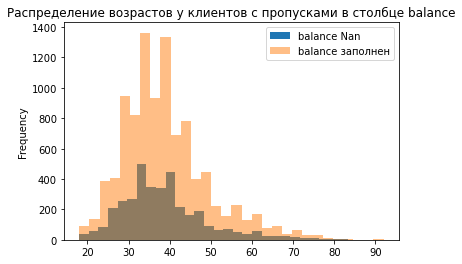

In [17]:
balance_nan.age.plot(kind='hist',bins=30, title='Распределение возрастов у клиентов с пропусками в столбце balance', label='balance Nan')
data_churn.age.plot(kind='hist',bins=30,label='balance заполнен', alpha=0.5)
plt.legend()
plt.show()

По распределению возрастов не вижу резких различий, на основе возвраста не могу сделать предположение о пропуске/заполнении balance.

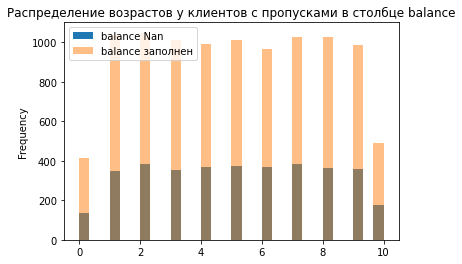

In [18]:
balance_nan.objects.plot(kind='hist',bins=30, title='Распределение возрастов у клиентов с пропусками в столбце balance', label='balance Nan')
data_churn.objects.plot(kind='hist',bins=30,label='balance заполнен', alpha=0.5)
plt.legend()
plt.show()

По количеству объектов тоже не вижу резких отличий.

In [19]:
products_nan = balance_nan.groupby('products', as_index = False)['user_id'].count()
products_not_nan = data_churn.groupby('products', as_index = False)['user_id'].count()
products_nan['products_not_nan'] = products_not_nan['user_id']
products_nan['share'] = (products_nan['user_id']/products_nan['products_not_nan']).map(lambda n: '{:,.2%}'.format(n))

In [20]:
products_nan

,products,user_id,products_not_nan,share
0,1,905,5084,17.80%
1,2,2600,4590,56.64%
2,3,98,266,36.84%
3,4,14,60,23.33%


Если смотрим по продуктам - максимальное количество пропусков у клиентов, которые пользуются двумя продуктами, в абсолютном и относительном выражении. В данном случае также сложно сделать конкретное предположение о природе пропусков.

In [21]:
balance_nan['estimated_salary'].describe()

count      3617.000000
mean      98983.559549
std       57730.828955
min          90.070000
25%       49506.820000
50%       98618.790000
75%      148330.970000
max      199992.480000
Name: estimated_salary, dtype: float64

In [22]:
data_churn['estimated_salary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64

In [23]:
balance_nan['score'].describe()

count    3617.000000
mean      649.452861
std        96.158798
min       350.000000
25%       583.000000
50%       651.000000
75%       717.000000
max       850.000000
Name: score, dtype: float64

In [24]:
data_churn['score'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: score, dtype: float64

По estimated salary и score тоже не вижу резких различий в параметрах.
Так как сложно сделать конкретные выводы о природе и неслучайности пропусков, в данном случае не буду их заполнять.

## Сформировать портреты клиентов, которые склонны уходить из банка
<a id="analysis"></a>

### Анализ оттока в зависимости от признака

Далее чтобы проанализировать ситуацию оттока, построю графики распределения признаков для тех, кто попал в отток и тех, кто не попал в отток.

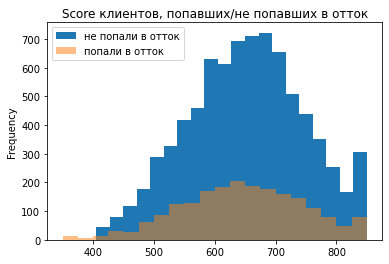

In [25]:
data_churn.query('churn == 0').score.plot(kind='hist',bins=20, title='Score клиентов, попавших/не попавших в отток', label='не попали в отток')
data_churn.query('churn == 1').score.plot(kind='hist',bins=20,label='попали в отток', alpha=0.5)
plt.legend()
plt.show()

In [26]:
data_churn.query('churn == 0')['score'].describe()

count    7963.000000
mean      651.853196
std        95.653837
min       405.000000
25%       585.000000
50%       653.000000
75%       718.000000
max       850.000000
Name: score, dtype: float64

In [27]:
data_churn.query('churn == 1')['score'].describe()

count    2037.000000
mean      645.351497
std       100.321503
min       350.000000
25%       578.000000
50%       646.000000
75%       716.000000
max       850.000000
Name: score, dtype: float64

Распределения баллов среди ушедших и оставшихся примерно похожи, схожи диапазоны значений, пики. По графику видно, что есть некоторое количество клиентов до 400, которое попадает в отток. Диапазон клиентов, которые не попадают в отток начинается с 400.

In [28]:
(data_churn.query('churn == 1').groupby('city')['user_id'].count()/data_churn.groupby('city')['user_id'].count()).map(lambda n: '{:,.2%}'.format(n))

city
Ростов Великий    32.44%
Рыбинск           16.67%
Ярославль         16.15%
Name: user_id, dtype: object

In [29]:
data_churn.query('churn == 1').groupby('city')['user_id'].count()

city
Ростов Великий    814
Рыбинск           413
Ярославль         810
Name: user_id, dtype: int64

По городам видим, что наибольший отток произошел по Ростову, около трети клиентов попали в отток, по остальным городам около 16-17%.

In [30]:
(data_churn.query('churn == 1').groupby('gender')['user_id'].count()/data_churn.groupby('gender')['user_id'].count()).map(lambda n: '{:,.2%}'.format(n))

gender
Ж    25.07%
М    16.46%
Name: user_id, dtype: object

In [31]:
data_churn.groupby('gender')['user_id'].count()

gender
Ж    4543
М    5457
Name: user_id, dtype: int64

In [32]:
data_churn.pivot_table(index = ['churn', 'gender'], columns = 'city', values = 'user_id', aggfunc = 'count')

city          Ростов Великий  Рыбинск  Ярославль
churn gender                                    
0     Ж                  745      858       1801
      М                  950     1206       2403
1     Ж                  448      231        460
      М                  366      182        350

В случае с полом видим, что клиентов мужского пола изначально было немного больше. Также видим, что отток произошел не совсем равномерно - четверть женщин попала в отток, и только ~16% мужчин.

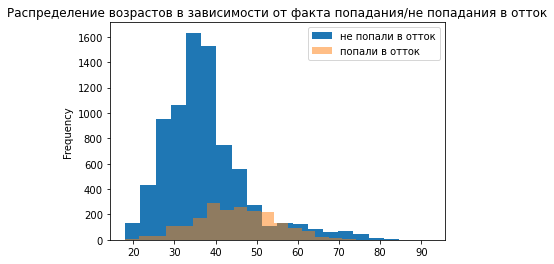

In [33]:
data_churn.query('churn == 0').age.plot(kind='hist',bins=20, title='Распределение возрастов в зависимости от факта попадания/не попадания в отток', label='не попали в отток')
data_churn.query('churn == 1').age.plot(kind='hist',bins=20,label='попали в отток', alpha=0.5)
plt.legend()
plt.show()

In [34]:
data_churn.query('churn == 1')['age'].describe()

count    2037.000000
mean       44.837997
std         9.761562
min        18.000000
25%        38.000000
50%        45.000000
75%        51.000000
max        84.000000
Name: age, dtype: float64

In [35]:
data_churn['age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

In [36]:
data_churn.pivot_table(index = ['churn', 'gender'], columns = 'city', values = 'age', aggfunc = 'median')

city          Ростов Великий  Рыбинск  Ярославль
churn gender                                    
0     Ж                   36       36         35
      М                   36       36         36
1     Ж                   45       44         45
      М                   45       44         45

In [37]:
data_churn.pivot_table(index = ['churn', 'gender'], columns = 'city', values = 'user_id', aggfunc = 'count')

city          Ростов Великий  Рыбинск  Ярославль
churn gender                                    
0     Ж                  745      858       1801
      М                  950     1206       2403
1     Ж                  448      231        460
      М                  366      182        350

В ситуации с возрастом уже видим, что распределения по тем, кто попал в отток и тем, кто не попал, различаются. В данном случае можно увидеть взаимосвязь между возрастом и оттоком. В отток в основном попадают клиенты 44-45 лет.

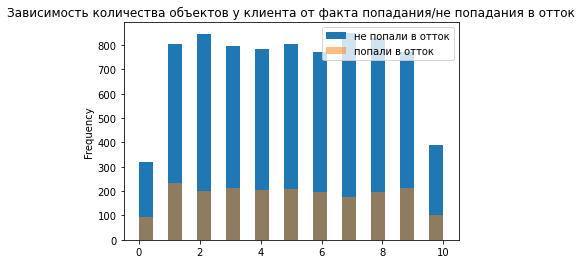

In [38]:
data_churn.query('churn == 0').objects.plot(kind='hist',bins=21, title='Зависимость количества объектов у клиента от факта попадания/не попадания в отток', label='не попали в отток')
data_churn.query('churn == 1').objects.plot(kind='hist',bins=21,label='попали в отток', alpha=0.5)
plt.legend()
plt.show()

In [39]:
(data_churn.query('churn == 1').groupby('objects')['user_id'].count()/data_churn.groupby('objects')['user_id'].count()).map(lambda n: '{:,.2%}'.format(n))

objects
0     23.00%
1     22.42%
2     19.18%
3     21.11%
4     20.53%
5     20.65%
6     20.27%
7     17.22%
8     19.22%
9     21.65%
10    20.61%
Name: user_id, dtype: object

По объектам - в каждом случае отток произошел примерно на 20%.

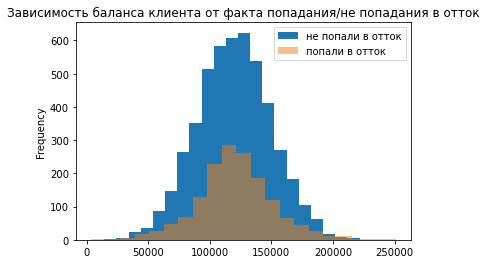

In [40]:
data_churn.query('churn == 0').balance.plot(kind='hist',bins=21, title='Зависимость баланса клиента от факта попадания/не попадания в отток', label='не попали в отток')
data_churn.query('churn == 1').balance.plot(kind='hist',bins=21,label='попали в отток', alpha=0.5)
plt.legend()
plt.show()

Распределения балансов очень похожи со схожими пиками, распределения похожи на нормальные.

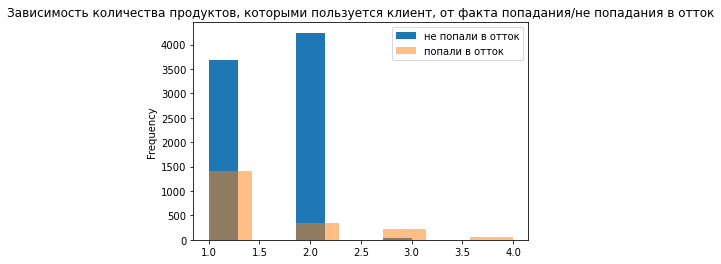

In [41]:
data_churn.query('churn == 0').products.plot(kind='hist',bins=7, title='Зависимость количества продуктов, которыми пользуется клиент, от факта попадания/не попадания в отток', label='не попали в отток')
data_churn.query('churn == 1').products.plot(kind='hist',bins=7,label='попали в отток', alpha=0.5)
plt.legend()
plt.show()

In [42]:
(data_churn.query('churn == 1').groupby('products')['user_id'].count()/data_churn.groupby('products')['user_id'].count()).map(lambda n: '{:,.2%}'.format(n))

products
1     27.71%
2      7.58%
3     82.71%
4    100.00%
Name: user_id, dtype: object

Сразу можно отметить, что изначально было очень мало клиентов, которые пользовались 3-4 продуктам. Клиенты, которые пользовались 4 продуктами, все попали в отток. Клиенты, которые пользовались 3 продуктам, попали в отток на ~на 83%. Можно предположить, что клиенты с количеством продуктов 3-4 участвовали в акции, а по истечению периода перестали пользоваться услугами банка. Также можно предположить, что доп. услуги были подключены клиентам случайно, с чем клиенты были не согласны и отказались от услуг банка. 

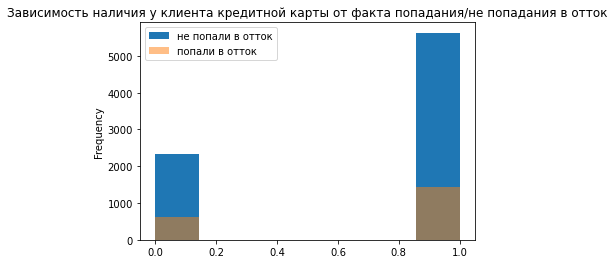

In [43]:
data_churn.query('churn == 0').credict_card.plot(kind='hist',bins=7, title='Зависимость наличия у клиента кредитной карты от факта попадания/не попадания в отток', label='не попали в отток')
data_churn.query('churn == 1').credict_card.plot(kind='hist',bins=7,label='попали в отток', alpha=0.5)
plt.legend()
plt.show()

In [44]:
(data_churn.query('churn == 1').groupby('credict_card')['user_id'].count()/data_churn.groupby('credict_card')['user_id'].count()).map(lambda n: '{:,.2%}'.format(n))

credict_card
0    20.81%
1    20.18%
Name: user_id, dtype: object

В данном случае не вижу закономерности от наличия/отсутствия карты у клиента и попаданием/не попаданием в отток.

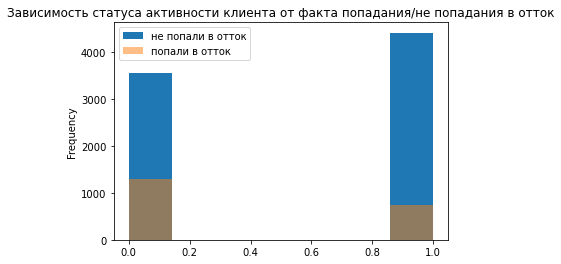

In [45]:
data_churn.query('churn == 0').loyalty.plot(kind='hist',bins=7, title='Зависимость статуса активности клиента от факта попадания/не попадания в отток', label='не попали в отток')
data_churn.query('churn == 1').loyalty.plot(kind='hist',bins=7,label='попали в отток', alpha=0.5)
plt.legend()
plt.show()

In [46]:
(data_churn.query('churn == 1').groupby('loyalty')['user_id'].count()/data_churn.groupby('loyalty')['user_id'].count()).map(lambda n: '{:,.2%}'.format(n))

loyalty
0    26.85%
1    14.27%
Name: user_id, dtype: object

У клиентов, которые имеют статус активных отток произошел ~ на 14%, у неактивных клиентов ~ на 27%. В данном случае не совсем понятно как присваивался статус клиенту. В связи с этим не могу сказать, что есть четкая взаимосвязь между теми, кто попал/не попал в отток и статусом активности клиента.

<AxesSubplot:title={'center':'estimated_salary'}, xlabel='churn'>

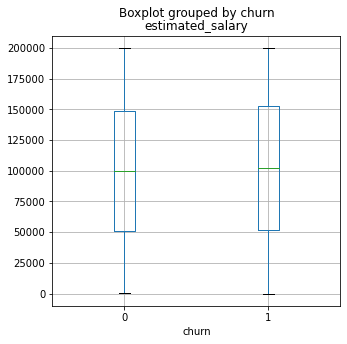

In [47]:
data_churn.boxplot(column='estimated_salary', by='churn', figsize=(5,5))

In [48]:
data_churn.query('churn == 0')['estimated_salary'].describe()

count      7963.000000
mean      99738.391772
std       57405.586966
min          90.070000
25%       50783.490000
50%       99645.040000
75%      148609.955000
max      199992.480000
Name: estimated_salary, dtype: float64

In [49]:
data_churn.query('churn == 1')['estimated_salary'].describe()

count      2037.000000
mean     101465.677531
std       57912.418071
min          11.580000
25%       51907.720000
50%      102460.840000
75%      152422.910000
max      199808.100000
Name: estimated_salary, dtype: float64

По графику и результатам метода describe, видим, что минимально, максимальное значения, среднее и значения квартилей похожи.

In [50]:
data_churn.pivot_table(index = ['churn', 'gender', 'products'], columns = 'city', values = 'score', aggfunc = 'median')

city                   Ростов Великий  Рыбинск  Ярославль
churn gender products                                    
0     Ж      1                  654.0    651.5      654.0
             2                  651.0    655.0      654.0
             3                  670.0    659.5      711.0
      М      1                  649.5    651.0      656.0
             2                  659.0    649.0      655.0
             3                  644.0    639.0      684.0
1     Ж      1                  655.0    652.5      649.0
             2                  644.0    646.0      645.5
             3                  649.0    645.0      618.5
             4                  613.5    698.0      653.0
      М      1                  637.0    636.0      646.0
             2                  651.0    685.5      616.0
             3                  657.5    683.0      651.0
             4                  666.0    517.5      635.5

Отдельно посмотрела средние значения по score в группировке по полу, городу и количеству продуктов. В целом не вижу сильных аномалий. Но есть бросающийся в глаза средний score по мужчинам из Рыбинска с 4 продуктами, который попал в отток.

In [51]:
data_churn.pivot_table(index = ['churn', 'gender', 'products'], columns = 'city', values = 'estimated_salary', aggfunc = 'median')

city                   Ростов Великий     Рыбинск   Ярославль
churn gender products                                        
0     Ж      1             112687.570  101570.170   93261.690
             2              98175.740  101874.925  101778.900
             3             176433.600   68389.230   81602.020
      М      1              94191.175   94906.550   97825.230
             2             104936.880   96300.475   98570.010
             3              63795.620  104331.980   81514.060
1     Ж      1             102628.560  111187.475  104469.060
             2              99475.950  126241.400   94775.935
             3             133556.940  112520.070   97485.440
             4             116403.465   83866.350  129964.560
      М      1              88604.890  107415.020  100075.100
             2             101300.940   81617.365  106977.530
             3              87572.795   81054.000  123916.700
             4             107598.130  120398.135  123046.875

Также если сделать ту же группировку по заработной плате, увидим, что клиенты, которые пользовались 4 продуктами и попали в отток имеют достаточно высокий уровень заработной платы.

Попробую разбить score на категории и сгруппировать по разным признакам.

In [52]:
data_churn['score'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: score, dtype: float64

In [53]:
def score_status(score):
    if score<584:
        return 'низкий'
    elif score>=584 and score<718:
        return 'средний'
    else:
        return 'высокий'

In [54]:
data_churn['score_status'] = data_churn['score'].apply(score_status)

In [55]:
data_churn.pivot_table(index = ['score_status'], columns = 'city', values = 'user_id', aggfunc = 'count')

city,Ростов Великий,Рыбинск,Ярославль
score_status,,,
высокий,656,605,1240
низкий,616,592,1283
средний,1237,1280,2491


По всем городам больше всего клиентов со средним score.

In [56]:
data_churn.pivot_table(index = ['score_status', 'gender'], columns = 'city', values = 'age', aggfunc = 'median')

city                 Ростов Великий  Рыбинск  Ярославль
score_status gender                                    
высокий      Ж                 38.0     38.0       37.0
             М                 37.0     38.0       36.0
низкий       Ж                 40.0     37.0       37.0
             М                 39.0     37.0       37.0
средний      Ж                 39.0     38.0       37.5
             М                 38.0     37.0       37.0

Средний возраст не отличается сильно в зависимости от score.

In [57]:
data_churn.pivot_table(index = ['score_status', 'gender'], columns = 'city', values = 'objects', aggfunc = 'mean')

city                 Ростов Великий   Рыбинск  Ярославль
score_status gender                                     
высокий      Ж             4.909677  5.148855   4.917117
             М             5.017341  5.026239   5.131387
низкий       Ж             4.880866  4.955466   5.035593
             М             5.109145  4.872464   4.936508
средний      Ж             5.033003  4.951724   4.921147
             М             5.036450  5.164286   5.065455

Количество объектов в собственности не зависит от score.

Изучив ситуацию оттока по каждому признаку, в целом, думаю, что нет каких-либо аномалий, связанных с оттоком. Также практически не видна четкая взаимосвязь оттока от признаков. Но в целом по результатам анализа можно сказать, что на склонность к оттоку могут повлиять параметры города, пола и возраста.

### Кластеризация клиентов

Далее проведу кластеризацию клиентов. Так как стандартизировать данные с пропусками не получится, столбец Balance не буду принимать во внимание.

Также переведу значения категориальных переменных в числовые.

In [58]:
data_churn = data_churn.drop(['score_status'], axis = 1)

In [59]:
data_churn = pd.get_dummies(data_churn)
print(data_churn.head())

    user_id  score  age  objects    balance  products  credict_card  loyalty  \
0  15677338    619   42        2        NaN         1             1        1   
1  15690047    608   41        1   83807.86         1             0        1   
2  15662040    502   42        8  159660.80         3             1        0   
3  15744090    699   39        1        NaN         2             0        0   
4  15780624    850   43        2  125510.82         1             1        1   

   estimated_salary  churn  city_Ростов Великий  city_Рыбинск  city_Ярославль  \
0         101348.88      1                    0             0               1   
1         112542.58      0                    0             1               0   
2         113931.57      1                    0             0               1   
3          93826.63      0                    0             0               1   
4          79084.10      0                    0             1               0   

   gender_Ж  gender_М  
0       

Далее построю матрицу корреляций прежде, чем проводить кластеризацию.

<AxesSubplot:>

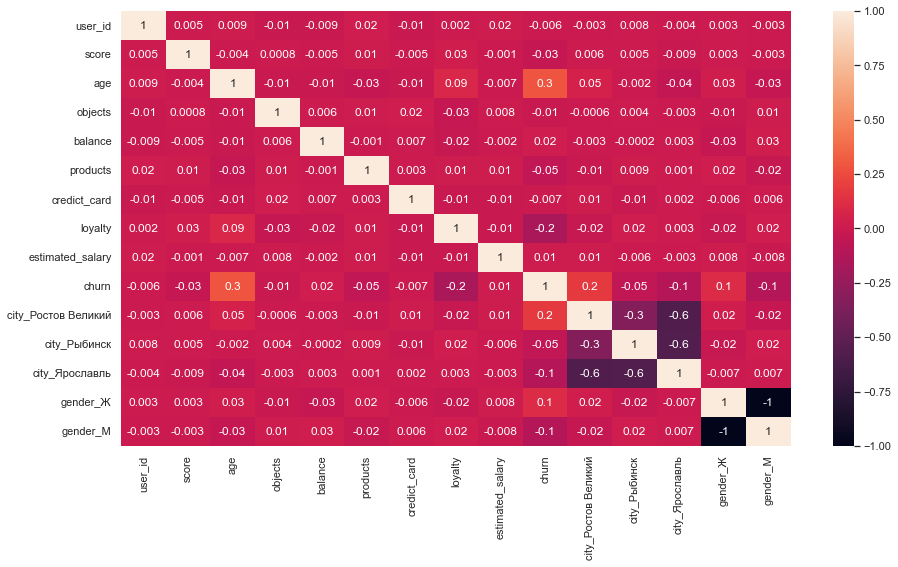

In [60]:
corr_m = data_churn.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr_m, annot = True, fmt='.1g')

По матрице корреляций видим, что есть мультиколлинеарные признаки, которые получились из-за перевода значений категориальных переменных в числовые. При запуске алгоритма буду учитывать женский пол и из городов - Ростов.

In [61]:
X = data_churn.drop(['churn', 'balance', 'gender_М', 'city_Рыбинск', 'city_Ярославль'], axis = 1)

In [62]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [63]:
linked = linkage(X, method = 'ward') 

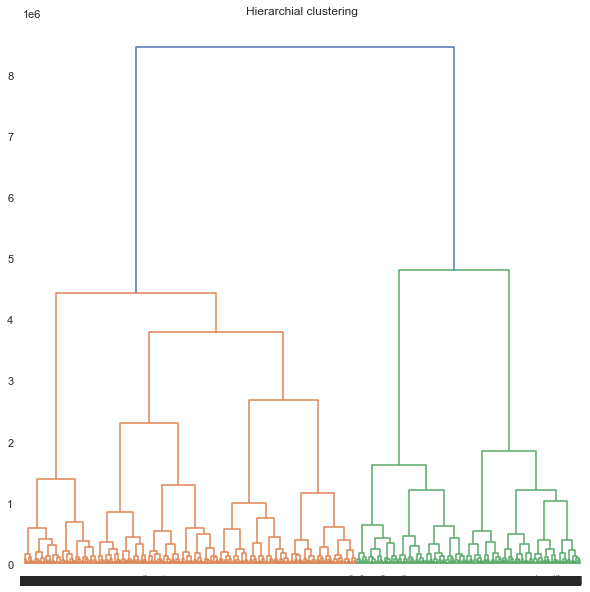

In [64]:
plt.figure(figsize=(10, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show() 

In [65]:
km = KMeans(n_clusters = 7, random_state = 0)
labels = km.fit_predict(X_sc)

In [66]:
data_churn['clusters'] = labels
data_churn.groupby('clusters').mean()

,user_id,score,age,objects,balance,products,credict_card,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
clusters,,,,,,,,,,,,,,,
0,1.573552e+07,653.672131,36.148505,5.006750,118504.227625,1.542912,1.000000,1.000000,98315.744802,0.124397,0.000000,0.319190,0.680810,1.000000,0.000000
1,1.573443e+07,649.290607,36.622309,4.975049,120075.185183,1.545010,0.000000,0.491194,102122.825470,0.160470,0.000000,0.339530,0.660470,0.449609,0.550391
2,1.573099e+07,648.400884,36.565954,5.167281,123175.611931,1.504053,1.000000,0.000000,100265.469484,0.163596,0.000000,0.310980,0.689020,0.000000,1.000000
3,1.573210e+07,652.725684,35.568389,5.047112,119517.755814,1.522796,1.000000,1.000000,98888.452736,0.068389,0.000000,0.334347,0.665653,0.000000,1.000000
4,1.573549e+07,649.593131,63.346103,4.838838,118258.529701,1.483487,0.701453,0.885073,93773.567252,0.268164,0.187583,0.287979,0.524439,0.442536,0.557464
5,1.573486e+07,647.679144,37.409982,4.961676,118545.462962,1.574866,1.000000,0.000000,100730.516934,0.265597,0.000000,0.331551,0.668449,1.000000,0.000000
6,1.573350e+07,651.869455,38.242924,5.020279,119723.948940,1.524715,0.714829,0.474863,101396.806037,0.324039,1.000000,0.000000,0.000000,0.477398,0.522602


Для кластеризации взяла число кластеров равное 7. Посмотрим на средние по кластерам. 

Параметры score, balance и salary не помогут определить закономерность оттока, они примерно одинаковы по кластерам.

По кластеру 3 наименьший отток. В данном кластере только мужчины, в основном из города Ярославль, средний возраст 35.5 лет, в среднем 5 объектов в собственности, в среднем пользуются 1-2 продуктами, статус активный.

Наибольший отток по кластеру 6. В данном кластере примерно одинаковое соотношение мужчин и женщин, город - Ростов, средний возраст - 38 лет, в среднем 5 объектов в собственности (как и у кластера 3), в среднем у большей части клиентов есть кредитная карта, по статусу почти у половины неактивный. 

## Проверка статистических гипотез
<a id="hypothesis"></a>

Далее необходимо проверить статистические гипотезы.

1. Гипотеза различия дохода между теми клиентами, которые ушли и теми, которые остались.

Нулевая гипотеза - средний доход между теми клиентами, которые ушли и теми, которые остались, не различается. Альтернативная - средний доход между теми клиентами, которые ушли и теми, которые остались различается. Зададим уровень значимости 5%

In [67]:
alpha = 0.05

In [68]:
churn_yes = data_churn.query('churn==1')
churn_no = data_churn.query('churn==0')
churn_yes_salary = churn_yes['estimated_salary'].to_list()
churn_no_salary = churn_no['estimated_salary'].to_list()

In [69]:
results = st.ttest_ind(churn_yes_salary, churn_no_salary)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.22644042802223346
Не получилось отвергнуть нулевую гипотезу


По результатам теста не получилось отвергнуть нулевую гипотезу. Вывод: средний доход между теми клиентами, которые ушли и теми, которые остались, не различается. 

Далее проверю вторую гипотезу.

2. Гипотеза различия баллов кредитного скоринга между теми клиентами, которые ушли и теми, которые остались.

Нулевая гипотеза - среднее количество баллов кредитного скоринга между теми клиентами, которые ушли и теми, которые остались, не различается. Альтернативная - среднее количество баллов кредитного скоринга между теми клиентами, которые ушли и теми, которые остались различается. Зададим уровень значимости 5%.

In [70]:
churn_yes_score = churn_yes['score'].to_list()
churn_no_score = churn_no['score'].to_list()

In [71]:
results = st.ttest_ind(churn_yes_score, churn_no_score)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.006738213892192373
Отвергаем нулевую гипотезу


По результатам теста следует отвергнуть нулевую гипотезу. Но ранее по исследованию я не связывала количество баллов кредитного скорринга клиентов с оттоком. Еще раз посмотрю распределение, на этот раз с помощью boxplot.

(350.0, 860.0)

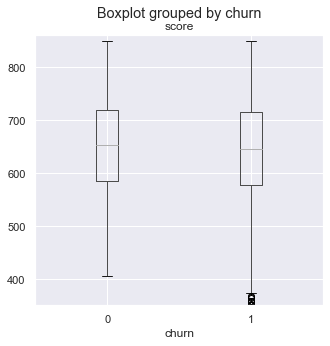

In [72]:
data_churn.boxplot(column='score', by='churn', figsize=(5,5))
plt.ylim(350,860)

Ранее я отмечала, что есть расхождения в начале диапазонов по клиентам, попавшим в отток, и теми, кто не попал. По графику боксплота вижу, что есть выбросы по клиентам, которые попали в отток.

In [73]:
churn_yes['score'].describe()

count    2037.000000
mean      645.351497
std       100.321503
min       350.000000
25%       578.000000
50%       646.000000
75%       716.000000
max       850.000000
Name: score, dtype: float64

Попробую избавиться от выбросов и еще раз провести тест. 

In [74]:
for_query = churn_yes['score'].quantile([0.01, 0.99], interpolation='nearest')
print(for_query)

0.01    404
0.99    850
Name: score, dtype: int64


Поставлю нижнюю границу на 380.

In [75]:
churn_yes = churn_yes.query('score > 380')

In [76]:
churn_yes_score_new = churn_yes['score'].to_list()
churn_no_score_new = churn_no['score'].to_list()

In [77]:
results = st.ttest_ind(churn_yes_score_new, churn_no_score_new)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.05855496567834601
Не получилось отвергнуть нулевую гипотезу


После исключения выбросов результаты теста поменялись. По результатам теста не получилось отвергнуть нулевую гипотезу. Вывод: среднее количество баллов кредитного скоринга между теми клиентами, которые ушли и теми, которые остались, не различается.

## Выводы и рекомендации
<a id="summary"></a>

Основные выводы:
    
В результате исследования был сформирован портрет клиентов, которые склонны уходить из банка.

 - средний возраст клиента - 44-45 лет
 - пол - скорее женский
 - город - Ростов Великий
 - в среднем имеет 5 объектов в собственности
 - в среднем у большей части клиентов есть кредитная карта
 - по статусу активности четких разграничений нет

Портрет клиента, который не склонен попадать в отток будет выглядеть следующим образом:

 - средний возраст - 36 лет
 - пол - мужской
 - город - Ярославль
 - в среднем имеет 5 объектов в собственности
 - в среднем у большей части клиентов есть кредитная карта
 - статус активный

Основные рекомендации:
    
На основе полученных выводов можно дать следующие рекомендации.

- с целью удержания аудитории 44-45 лет для данной категории клиентов давать дополнительные инструкции по использованию продуктов, обеспечить простоту их использования. Также можно предложить дополнительную страховку или продукт по управлению пенсионными накоплениями. 
- так как женщины более склонны к оттоку, разработать продукт под данную аудиторию, например, кредитные продукты для женщин-предпринимателей. Также можно разработать кобрендовые карты в зависимости от потребностей клиенток банка.
- пересмотреть необходимость филиала в Ростове, так как наибольший отток произошел оттуда. Население Ростова сравнительно меньше двух других городов, поэтому стоит обратить внимание на целесообразность обеспечения функционирования филиала.